In [58]:
####################### get packages #######################

import psycopg2
from sqlalchemy import create_engine, DateTime, Float, String, Integer, Column
from dotenv import load_dotenv
import os
import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np

####################### get station info from database #######################

# Load login data from .env file
load_dotenv()

DB_NAME = os.getenv('DB_NAME')
DB_USERNAME = os.getenv('DB_USERNAME')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')

DB_STRING = f'postgresql://{DB_USERNAME}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'

# Create SQLAlchemy engine
engine = create_engine(DB_STRING)

# Create a new connection using psycopg2 for non-pandas operations
conn = psycopg2.connect(
    database=DB_NAME,
    user=DB_USERNAME,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

try:
    cursor = conn.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to -", record, "\n")
    
    # Load data from the database using SQLAlchemy engine   
    query_string1 = 'SELECT * FROM "02_silver"."dim_weather_stations"'
    weather_stations = pd.read_sql(query_string1, engine)    
    stations_id = weather_stations.stations_id.to_list()    
    stations_latitude = weather_stations.latitude.to_list()
    stations_longitude = weather_stations.longitude.to_list()
    
    query_string2 = 'select *  from "01_bronze".raw_open_meteo_weather_forecast'
    weather_forecast_raw_table = pd.read_sql(query_string2, engine)

except Exception as error:
    print("Error while connecting to PostgreSQL:", error)
    
finally:
    if conn:
        cursor.close()
        conn.close()
        print("PostgreSQL connection is closed")


####################### get weather forecast from api and push it into new table #######################

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)

timezone = "Europe/Berlin"
weather_variables = [
            "temperature_2m",
            "relative_humidity_2m",
            "apparent_temperature",
            "precipitation",
            "cloud_cover",
            "wind_speed_10m",
            "wind_direction_10m",
            "direct_radiation",
            "diffuse_radiation",
            "sunshine_duration"
        ]

# Function to fetch weather data for a specific station
def fetch_weather_data(station_id, latitude, longitude):
    url = "https://api.open-meteo.com/v1/dwd-icon"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "hourly": weather_variables,
        "timezone": timezone,
        "past_days": 2
    }
    response = retry_session.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    
    hourly = data['hourly']
    dates = pd.date_range(
        start=pd.to_datetime(hourly['time'][0], utc=False),
        periods=len(hourly['time']),
        freq=pd.Timedelta(hours=1)
    )
    
    dates = dates.tz_localize(timezone, ambiguous='NaT', nonexistent='shift_forward')
    timestamp_fetched = pd.to_datetime('today').tz_localize(timezone).floor('h')
        
    hourly_data = pd.DataFrame({
        'timestamp': dates,
        'timestamp_fetched': timestamp_fetched,
        'stations_id': station_id,
        'temperature_2m': hourly['temperature_2m'],
        'relative_humidity_2m': hourly['relative_humidity_2m'],
        'apparent_temperature': hourly['apparent_temperature'],
        'precipitation': hourly['precipitation'],
        'cloud_cover': hourly['cloud_cover'],
        'wind_speed_10m': hourly['wind_speed_10m'],
        'wind_direction_10m': hourly['wind_direction_10m'],
        'direct_radiation': hourly['direct_radiation'],
        'diffuse_radiation': hourly['diffuse_radiation'],
        'sunshine_duration': hourly['sunshine_duration']               
    })
    
    return hourly_data

all_data = []

print("Fetching data from API...")
for i in range(len(stations_id)):
    station_data = fetch_weather_data(stations_id[i], stations_latitude[i], stations_longitude[i])
    all_data.append(station_data)    
    
# Combine all data into a single DataFrame
forecast_data_new = pd.concat(all_data, ignore_index=True)
print("Done")

You are connected to - ('PostgreSQL 16.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 7.3.1 20180712 (Red Hat 7.3.1-12), 64-bit',) 

PostgreSQL connection is closed
Fetching data from API...
Done


In [59]:
forecast_data_new.head()

,timestamp,timestamp_fetched,stations_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,sunshine_duration
0,2024-06-29 00:00:00+02:00,2024-07-01 15:00:00+02:00,183,17.5,73,14.1,0.0,100,28.9,284,0.0,0.0,0.0
1,2024-06-29 01:00:00+02:00,2024-07-01 15:00:00+02:00,183,17.2,74,14.1,0.0,54,26.8,277,0.0,0.0,0.0
2,2024-06-29 02:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.6,77,14.4,0.0,0,20.8,279,0.0,0.0,0.0
3,2024-06-29 03:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.4,76,14.8,0.0,0,15.2,275,0.0,0.0,0.0
4,2024-06-29 04:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.0,80,14.7,0.0,3,14.0,258,0.0,0.0,0.0


In [60]:
forecast_data_new["forecast_hours"] = ((forecast_data_new['timestamp'] - forecast_data_new['timestamp_fetched']).dt.total_seconds() / 3600).astype(int)
forecast_data_new.tail()

,timestamp,timestamp_fetched,stations_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,sunshine_duration,forecast_hours
5179,2024-07-07 19:00:00+02:00,2024-07-01 15:00:00+02:00,5792,4.1,88,1.7,0.0,100,4.4,351,10.0,51.0,0.0,148
5180,2024-07-07 20:00:00+02:00,2024-07-01 15:00:00+02:00,5792,3.8,88,1.6,0.0,100,3.3,354,7.0,31.0,0.0,149
5181,2024-07-07 21:00:00+02:00,2024-07-01 15:00:00+02:00,5792,3.5,89,1.3,0.1,95,2.2,351,2.0,10.0,0.0,150
5182,2024-07-07 22:00:00+02:00,2024-07-01 15:00:00+02:00,5792,3.1,91,1.1,0.1,91,1.0,315,0.0,0.0,0.0,151
5183,2024-07-07 23:00:00+02:00,2024-07-01 15:00:00+02:00,5792,2.8,92,0.8,0.1,86,0.7,270,0.0,0.0,0.0,152


In [61]:
forecast_data_new.head()

,timestamp,timestamp_fetched,stations_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,sunshine_duration,forecast_hours
0,2024-06-29 00:00:00+02:00,2024-07-01 15:00:00+02:00,183,17.5,73,14.1,0.0,100,28.9,284,0.0,0.0,0.0,-63
1,2024-06-29 01:00:00+02:00,2024-07-01 15:00:00+02:00,183,17.2,74,14.1,0.0,54,26.8,277,0.0,0.0,0.0,-62
2,2024-06-29 02:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.6,77,14.4,0.0,0,20.8,279,0.0,0.0,0.0,-61
3,2024-06-29 03:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.4,76,14.8,0.0,0,15.2,275,0.0,0.0,0.0,-60
4,2024-06-29 04:00:00+02:00,2024-07-01 15:00:00+02:00,183,16.0,80,14.7,0.0,3,14.0,258,0.0,0.0,0.0,-59


In [62]:
forecast_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype                        
---  ------                --------------  -----                        
 0   timestamp             5184 non-null   datetime64[ns, Europe/Berlin]
 1   timestamp_fetched     5184 non-null   datetime64[ns, Europe/Berlin]
 2   stations_id           5184 non-null   object                       
 3   temperature_2m        5184 non-null   float64                      
 4   relative_humidity_2m  5184 non-null   int64                        
 5   apparent_temperature  5184 non-null   float64                      
 6   precipitation         5184 non-null   float64                      
 7   cloud_cover           5184 non-null   int64                        
 8   wind_speed_10m        5184 non-null   float64                      
 9   wind_direction_10m    5184 non-null   int64                        
 10  direct_radia

In [63]:
weather_forecast_raw_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608 entries, 0 to 4607
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   timestamp             4608 non-null   datetime64[ns, UTC]
 1   timestamp_fetched     4608 non-null   datetime64[ns, UTC]
 2   stations_id           4608 non-null   object             
 3   temperature_2m        4608 non-null   float64            
 4   relative_humidity_2m  4608 non-null   int64              
 5   apparent_temperature  4608 non-null   float64            
 6   precipitation         4608 non-null   float64            
 7   cloud_cover           4608 non-null   int64              
 8   wind_speed_10m        4608 non-null   float64            
 9   wind_direction_10m    4608 non-null   int64              
 10  direct_radiation      4608 non-null   float64            
 11  diffuse_radiation     4608 non-null   float64            
 12  sunshi

In [113]:
weather_forecast_raw_table["timestamp"] = weather_forecast_raw_table.timestamp.dt.tz_convert(timezone)
weather_forecast_raw_table["timestamp_fetched"] = weather_forecast_raw_table.timestamp_fetched.dt.tz_convert(timezone)
weather_forecast_raw_table["forecast_hours"] = ((weather_forecast_raw_table['timestamp'] - weather_forecast_raw_table['timestamp_fetched']).dt.total_seconds() / 3600).astype(int)

In [106]:
weather_forecast_raw_table.head()

,timestamp,timestamp_fetched,stations_id,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,sunshine_duration,forecast_hours
0,2024-06-27 00:00:00+02:00,2024-06-28 14:21:08+02:00,183,17.3,87,17.4,0.0,0,11.3,83,0.0,0.0,0.0,-38
1,2024-06-27 01:00:00+02:00,2024-06-28 14:21:08+02:00,183,16.9,89,17.2,0.0,0,9.7,59,0.0,0.0,0.0,-37
2,2024-06-27 02:00:00+02:00,2024-06-28 14:21:08+02:00,183,16.9,92,17.6,0.0,0,8.1,69,0.0,0.0,0.0,-36
3,2024-06-27 03:00:00+02:00,2024-06-28 14:21:08+02:00,183,17.5,91,18.3,0.0,0,8.5,62,0.0,0.0,0.0,-35
4,2024-06-27 04:00:00+02:00,2024-06-28 14:21:08+02:00,183,17.6,91,18.7,0.0,79,7.1,66,0.0,0.0,0.0,-34


In [108]:
silver_forecast = pd.concat([weather_forecast_raw_table,forecast_data_new], ignore_index=True)

In [109]:
silver_forecast.duplicated(subset=["stations_id","timestamp","forecast_hours"]).value_counts()

False    9792
Name: count, dtype: int64

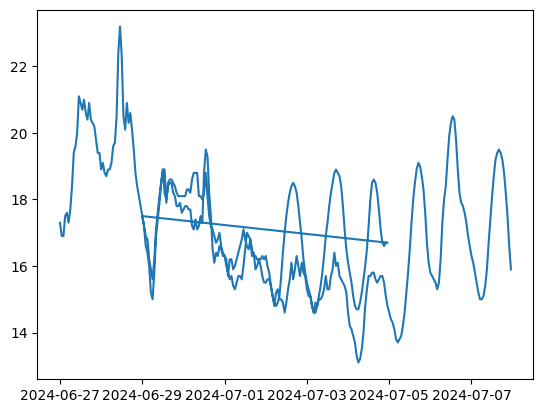

In [115]:
import matplotlib.pyplot as plt
temp_183 = silver_forecast.query('stations_id == "183"')
plt.plot(temp_183["timestamp"], temp_183["temperature_2m"])

In [114]:
silver_forecast.timestamp_fetched.unique()

<DatetimeArray>
['2024-06-28 14:21:08+02:00', '2024-07-01 15:00:00+02:00']
Length: 2, dtype: datetime64[ns, Europe/Berlin]